In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"buligon","key":"2340caf11b8855ec5bc27f098ecd8c0c"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d a2015003713/militaryaircraftdetectiondataset

100% 10.8G/10.8G [10:48<00:00, 17.9MB/s]
100% 10.8G/10.8G [10:48<00:00, 17.8MB/s]


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('militaryaircraftdetectiondataset.zip', 'r')
zip_ref.extractall('/dataset')
zip_ref.close()

In [3]:
import tensorflow as tf
from tensorflow.keras import layers, applications, optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def plota_historico_modelo(historico_modelo):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    axs[0].plot(range(1,len(historico_modelo.history['accuracy'])+1),
                historico_modelo.history['accuracy'],'r')
    axs[0].plot(range(1,len(historico_modelo.history['val_accuracy'])+1),
                historico_modelo.history['val_accuracy'],'b')
    axs[0].set_title('Acurácia do Modelo')
    axs[0].set_ylabel('Acuracia')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1, len(historico_modelo.history['accuracy']) + 1, 1))

    axs[0].legend(['training accuracy', 'validation accuracy'], loc='best')

    axs[1].plot(range(1,len(historico_modelo.history['loss'])+1),
                historico_modelo.history['loss'],'r')
    axs[1].plot(range(1,len(historico_modelo.history['val_loss'])+1),
                historico_modelo.history['val_loss'],'b')
    axs[1].set_title('Perda/Loss do Modelo')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1, len(historico_modelo.history['loss']) + 1, 1))
    axs[1].legend(['training loss', 'validation Loss'], loc='best')
    fig.savefig('historico_modelo_mod01.png')
    plt.show()

In [5]:
dataset_directory = 'dataset/crop'
batch_size = 40

In [6]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_directory,
    validation_split=0.3,
    subset="training",
    shuffle=True,
    image_size=(128, 128),
    batch_size = batch_size,
    seed=123  # set seed to make sure that there is no overlap between the training and validation subset
)

validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_directory,
    validation_split=0.3,
    subset="validation",
    shuffle=True,
    image_size=(128, 128),
    batch_size = batch_size,
    seed=123  # set seed to make sure that there is no overlap between the training and validation subset
)

Found 19018 files belonging to 43 classes.
Using 13313 files for training.
Found 19018 files belonging to 43 classes.
Using 5705 files for validation.


In [7]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_data = validation_dataset.take(val_batches//5)
val_data = validation_dataset.skip(val_batches//5)

class_names = train_dataset.class_names

In [8]:
AUTOTUNE = tf.data.AUTOTUNE
train_prefetch = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_prefetch = val_data.prefetch(buffer_size=AUTOTUNE)
test_prefetch = test_data.prefetch(buffer_size=AUTOTUNE)

train_prefetch = train_prefetch.map(lambda x, y: (x, tf.one_hot(y, len(class_names))))
val_prefetch = val_data.map(lambda x, y: (x, tf.one_hot(y, len(class_names))))

# Training the model

In [ ]:
model = Sequential()

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(factor=0.4, fill_mode="wrap"),
    layers.experimental.preprocessing.RandomContrast(factor=0.2)

])

preprocess_input = applications.resnet50.preprocess_input

pretrained_model = ResNet50(
    include_top=False,
    input_shape=(128, 128, 3),
    weights='imagenet'
)
pretrained_model.trainable = False

global_avg = layers.GlobalAveragePooling2D()
output_layer = layers.Dense(len(class_names), activation='softmax')

94765736/94765736 [==============================] - 5s 0us/step


In [ ]:
inputs = tf.keras.Input(shape=(128, 128, 3))
x = data_augmentation(inputs)
x = preprocess_input(inputs)
x = pretrained_model(x)
x = global_avg(x)
outputs = output_layer(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 tf.__operators__.getitem (  (None, 128, 128, 3)       0         
 SlicingOpLambda)                                                
                                                                 
 tf.nn.bias_add (TFOpLambda  (None, 128, 128, 3)       0         
 )                                                               
                                                                 
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                             

In [29]:
model.compile(loss="categorical_crossentropy",
              optimizer=Adam(optimizers.schedules.CosineDecay(0.0001, 500)),
              metrics=['accuracy'])


Epoch 1/5
338/338 [==============================] - 98s 211ms/step - loss: 0.0358 - accuracy: 0.9921 - val_loss: 0.7244 - val_accuracy: 0.8225
Epoch 2/5
338/338 [==============================] - 70s 203ms/step - loss: 0.0090 - accuracy: 0.9987 - val_loss: 0.7015 - val_accuracy: 0.8286
Epoch 3/5
338/338 [==============================] - 68s 199ms/step - loss: 0.0068 - accuracy: 0.9997 - val_loss: 0.6996 - val_accuracy: 0.8295
Epoch 4/5
338/338 [==============================] - 72s 209ms/step - loss: 0.0070 - accuracy: 0.9995 - val_loss: 0.7023 - val_accuracy: 0.8282
Epoch 5/5
338/338 [==============================] - 69s 201ms/step - loss: 0.0070 - accuracy: 0.9996 - val_loss: 0.7025 - val_accuracy: 0.8284


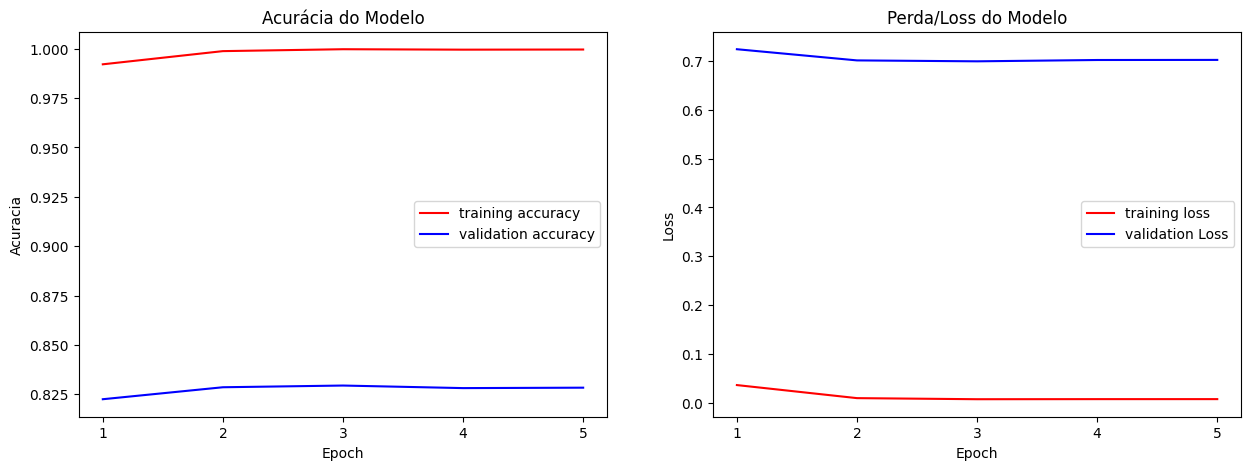

In [30]:
history = model.fit(train_prefetch, validation_data=(val_prefetch), epochs = 5)

plota_historico_modelo(history)

In [31]:
total_layers = len(pretrained_model.layers)
print(f"Total number of layers: {total_layers}")

Total number of layers: 175


In [40]:
pretrained_model.trainable = True
for layer in pretrained_model.layers[:110]:
    layer.trainable = False

In [38]:
optimizer = optimizers.RMSprop(learning_rate = optimizers.schedules.CosineDecay(0.000001, 500))
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

Epoch 5/10
337/338 [============================>.] - ETA: 0s - loss: 0.0033 - accuracy: 1.0000
Epoch 5: val_loss improved from inf to 0.68975, saving model to modelo.h5
338/338 [==============================] - 66s 193ms/step - loss: 0.0033 - accuracy: 1.0000 - val_loss: 0.6898 - val_accuracy: 0.8301
Epoch 6/10
337/338 [============================>.] - ETA: 0s - loss: 0.0031 - accuracy: 1.0000
Epoch 6: val_loss improved from 0.68975 to 0.67455, saving model to modelo.h5
338/338 [==============================] - 69s 202ms/step - loss: 0.0033 - accuracy: 0.9999 - val_loss: 0.6745 - val_accuracy: 0.8349
Epoch 7/10
337/338 [============================>.] - ETA: 0s - loss: 0.0032 - accuracy: 1.0000
Epoch 7: val_loss did not improve from 0.67455
338/338 [==============================] - 67s 196ms/step - loss: 0.0032 - accuracy: 1.0000 - val_loss: 0.6908 - val_accuracy: 0.8314
Epoch 8/10
337/338 [============================>.] - ETA: 0s - loss: 0.0033 - accuracy: 1.0000
Epoch 8: val_lo

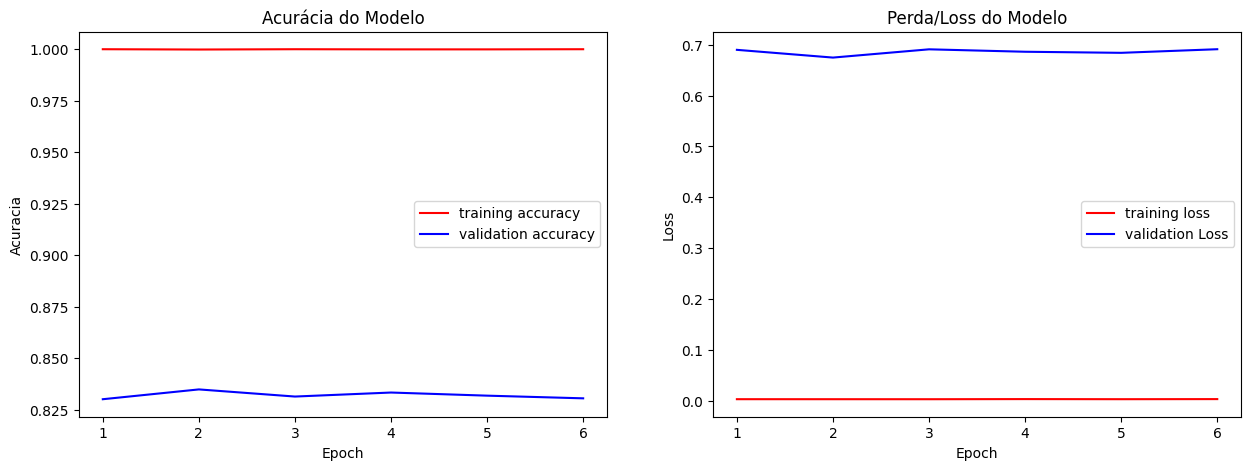

In [41]:
arquivo_modelo = "modelo.h5"
checkpointer = ModelCheckpoint(arquivo_modelo, monitor='val_loss', verbose=1, save_best_only=True)

history_final = model.fit(train_prefetch, validation_data=(val_prefetch), epochs = 10, callbacks=[checkpointer], initial_epoch=history.epoch[-1])
plota_historico_modelo(history_final)

In [42]:
image_batch, label_batch = test_prefetch.as_numpy_iterator().next()
predicted_labels = np.argmax(model.predict(image_batch), axis=1)

2/2 [==============================] - 1s 46ms/step


In [43]:
label_vs_prediction = np.transpose(np.vstack((label_batch, predicted_labels)))
print(label_vs_prediction)

[[42  5]
 [26 26]
 [37  9]
 [24 24]
 [18 18]
 [38 38]
 [17 17]
 [30 18]
 [ 0  0]
 [10  0]
 [18 18]
 [ 6  6]
 [16 16]
 [34 34]
 [36 36]
 [32 17]
 [ 8  8]
 [37 37]
 [12 12]
 [21 21]
 [21 21]
 [ 8  8]
 [10 10]
 [21 21]
 [18 18]
 [ 4  4]
 [35 28]
 [19 19]
 [17 17]
 [ 8 37]
 [17 17]
 [ 6  6]
 [21 39]
 [18 18]
 [40 40]
 [ 5 18]
 [20 20]
 [17 17]
 [16 19]
 [24 24]]


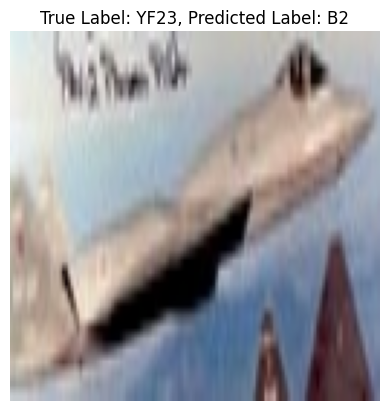

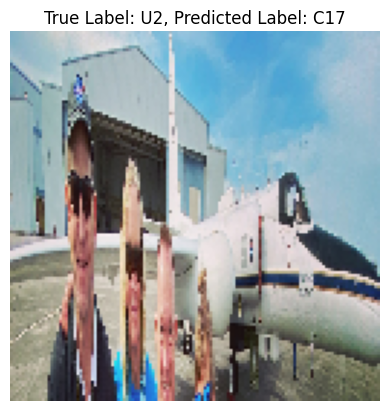

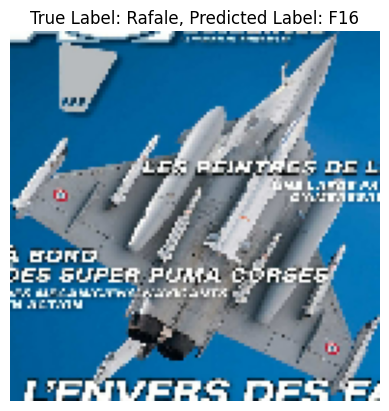

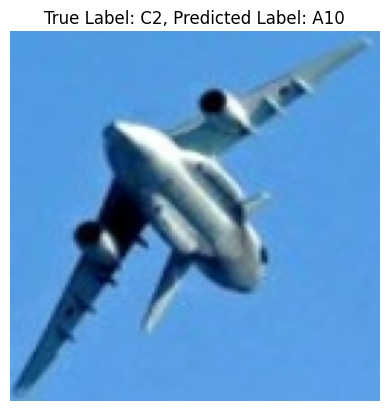

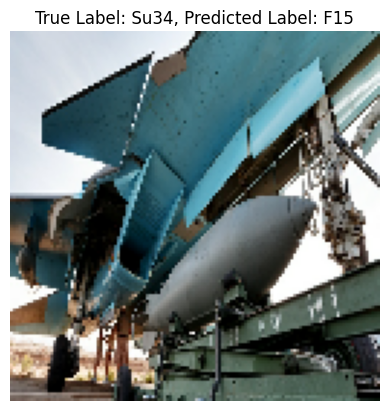

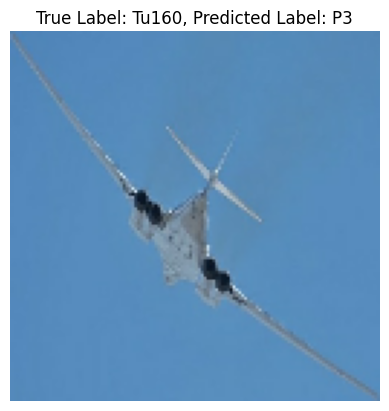

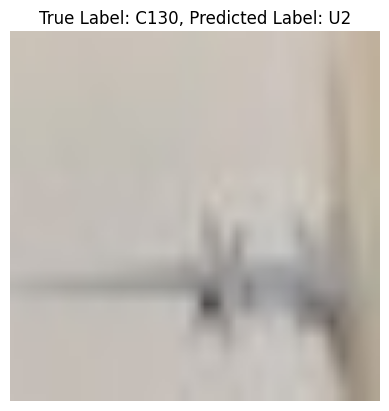

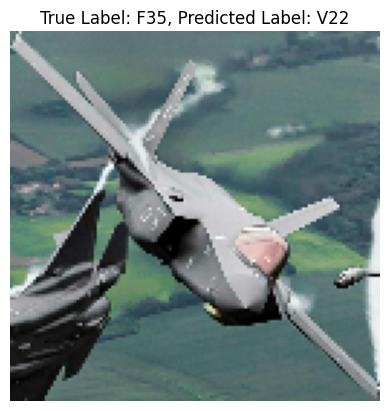

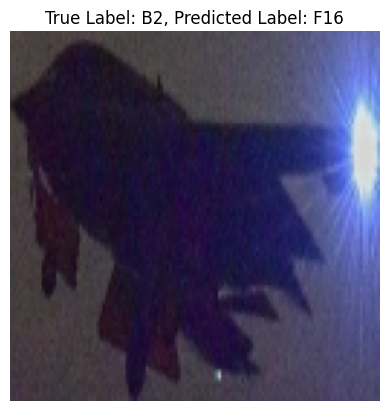

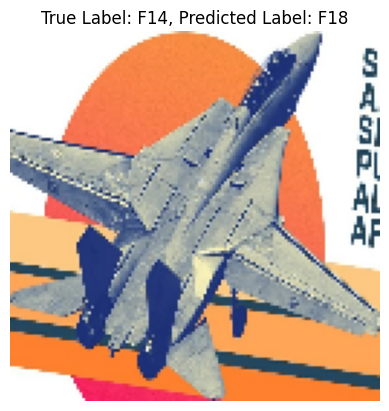

In [44]:
for image, true_label, predicted_label in zip(image_batch, label_batch, predicted_labels):
    if true_label != predicted_label:
        true_class_name = class_names[true_label]
        predicted_class_name = class_names[predicted_label]

        plt.figure()
        plt.imshow(image.astype("uint8"))
        plt.title(f'True Label: {true_class_name}, Predicted Label: {predicted_class_name}')
        plt.axis('off')

plt.show()

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

model = tf.keras.models.load_model('modelo.h5')

def get_true_and_predicted_labels(model, dataset):
    true_labels = []
    predicted_labels = []

    for images, labels in dataset:
        true_labels.extend(tf.argmax(labels, axis=1))
        predicted_labels.extend(np.argmax(model.predict(images), axis=1))

    return true_labels, predicted_labels

true_labels, predicted_labels = get_true_and_predicted_labels(model, val_prefetch)

confusion = confusion_matrix(true_labels, predicted_labels)

1/1 [==============================] - 1s 558ms/step


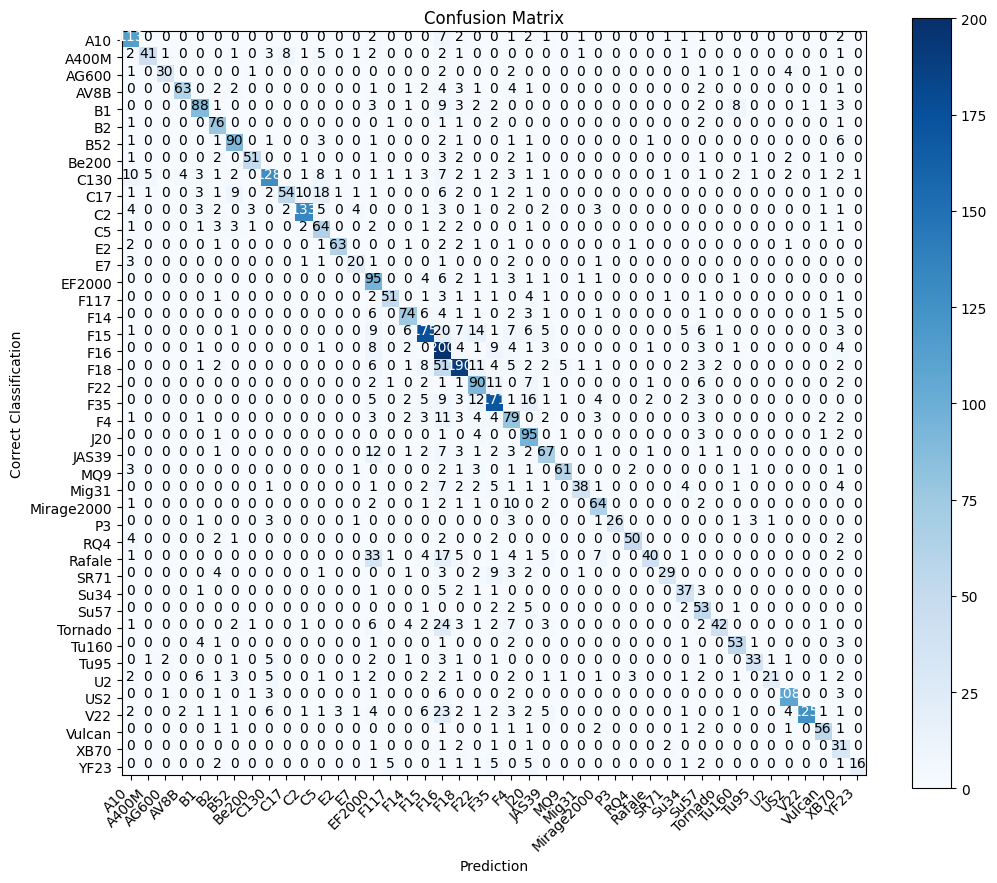

In [23]:
def plot_confusion_matrix(confusion, class_names):
    plt.imshow(confusion, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()

    tick_marks = np.arange(len(class_names))
    
    plt.xticks(tick_marks, class_names, rotation=45, ha='right') 
    plt.yticks(tick_marks, class_names)
    
    fmt = 'd'
    thresh = confusion.max() / 2.
    
    for i, j in itertools.product(range(confusion.shape[0]), range(confusion.shape[1])):
        plt.text(j, i, format(confusion[i, j], fmt),
                horizontalalignment="center",
                color="white" if confusion[i, j] > thresh else "black")
    
    plt.ylabel('Correct Classification')
    plt.xlabel('Prediction')

plt.figure(figsize=(12, 10)) 

plot_confusion_matrix(confusion, class_names)
plt.show()